# This notebook is an example notebook to inference autoencdoer.

In [2]:
import argparse, os, sys, glob
# sys.path.append(os.getcwd()+"/sdm")
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as T
transform = T.ToPILImage()

/home/m288756/anaconda3/envs/sdm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# yaml_path = "/home/m288756/stable-diffusion/models/first_stage_models/kl-f4/config_512.yaml"
# #data_path = "/mayo_atlas/home/m288756/stable-diffusion/data/inpainting_histo/"
# data_path = "/mayo_atlas/home/m288756/stable-diffusion/data/oneImage/"
data_path = "/mayo_atlas/home/m288756/stable-diffusion/data/oneNatural/"

yaml_path = "/home/m288756/stable-diffusion/models/first_stage_models/kl-f4/config_512.yaml"
ckpt_path = "/mayo_atlas/home/m288756/stable-diffusion/logs/2023-12-20T16-08-42_autoencoder_kl_64x64x3_TCGA_512/checkpoints/last.ckpt"
# ckpt_path = "/home/m288756/stable-diffusion/logs/2023-12-20T16-08-42_autoencoder_kl_64x64x3_TCGA_512/checkpoints/trainstep_checkpoints/epoch=000048-step=000173999.ckpt"

# yaml_path = "/home/m288756/stable-diffusion/models/first_stage_models/kl-f4/config_512.yaml"
# ckpt_path = "/mayo_atlas/home/m288756/stable-diffusion/models/first_stage_models/kl-f4/model.ckpt"

# yaml_path = "/mayo_atlas/home/m288756/stable-diffusion/models/first_stage_models/vq-f4/config_512.yaml"
# ckpt_path = "/mayo_atlas/home/m288756/stable-diffusion/models/first_stage_models/vq-f4/model.ckpt"

In [18]:
class Image_dataset(Dataset):
    def __init__(self, size, data_root, config=None):
        self.size = size
        self.data_root=data_root
        self.image_list = []
        
        for image in os.listdir(data_root):
            self.image_list.append(data_root+"/"+image)
                        

    def __len__(self):
        return len(self.image_list)


    def __getitem__(self, i):

        image = np.array(Image.open(self.image_list[i]).convert("RGB").crop((0, 0, self.size, self.size))) #.crop((self.size,self.size))) #.resize((self.size,self.size)))
        image = image.astype(np.float32) / 255.0#
        image = image[None].transpose(0,3,1,2)
        #image = image[None].transpose(0,3,1,2)
        image = torch.from_numpy(image)
        
        

        batch = {"image": np.squeeze(image,0)}
        for k in batch:
            batch[k] = batch[k] * 2.0 - 1.0

        return batch

In [19]:
##load the config
config_auto = OmegaConf.load(yaml_path)

##generate the model from config
auto = instantiate_from_config(config_auto.model)

##load the state dict
auto.load_state_dict(torch.load(ckpt_path)['state_dict'],strict=False)

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 128, 128) = 49152 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


<All keys matched successfully>

In [20]:
dataSet=Image_dataset(512,data_path)
loader = DataLoader(
    dataSet,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

In [21]:
batch=next(iter(loader))

In [22]:
##using cpu, not gpu
output=auto(batch['image'])

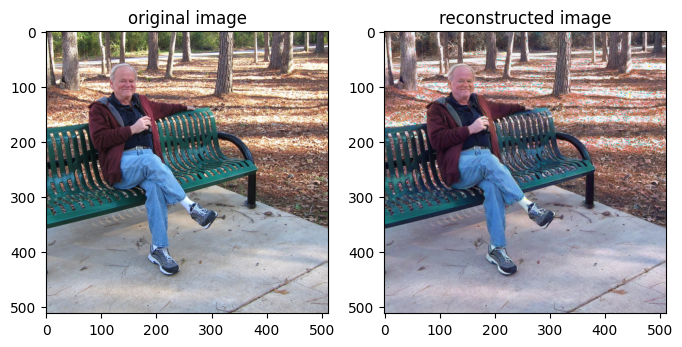

In [23]:

##Original Image
original_image=transform(batch['image'][0]*0.5+0.5)
##Output Image
output_image=transform(output[0][0]*0.5+0.5)

fig, axes = plt.subplots(1, 2, figsize=(8, 4)) 

# Display each image on a separate subplot
axes[0].imshow(original_image)
axes[0].set_title('original image')

axes[1].imshow(output_image)
axes[1].set_title('reconstructed image')


plt.show()

# # save the image and the output into outputs/autoencoder/ as 512x512  size png
# original_image.save("outputs/autoencoder/vq_original_natural.png")
# output_image.save("outputs/autoencoder/vq_output_natural.png")

# # save the image and the output into outputs/autoencoder/ as 512x512  size png
# original_image.save("outputs/autoencoder/kl_original_natural.png")
# output_image.save("outputs/autoencoder/kl_output_natural.png")

# save the image and the output into outputs/autoencoder/ as 512x512  size png
original_image.save("outputs/autoencoder/mine_original_natural.png")
output_image.save("outputs/autoencoder/mine_output_natural.png")


# # save the image and the output into outputs/autoencoder/ as 512x512  size png
# original_image.save("outputs/autoencoder/vq_original.png")
# output_image.save("outputs/autoencoder/vq_output.png")

# # save the image and the output into outputs/autoencoder/ as 512x512  size png
# original_image.save("outputs/autoencoder/kl_original.png")
# output_image.save("outputs/autoencoder/kl_output.png")

# # save the image and the output into outputs/autoencoder/ as 512x512  size png
# original_image.save("outputs/autoencoder/mine_original.png")
# output_image.save("outputs/autoencoder/mine_output.png")